# EE 538: Analog Circuits for Sensor Systems
## Autumn 2020
## Instructor: Jason Silver

## Announcements

 - Solution to Assignment 4 posted on JupyterHub and Canvas
 - Assignment 5 due Sunday, November 8 at midnight
    - Jupyter Notebook (.ipyb) submission on Canvas
    - For LTspice problems, include image (e.g. screen capture) of schematic(s)

## Week 6

 - Art of Electronics (AoE) Chapter 8

## Overview

- Last time...
    - Sources of error
    - Differential signaling
    - Difference amplifier
    - Instrumentation amplifier
- Today...
    - Types of noise
    - Noise in resistors
    - Noise bandwidth
    - Transistor noise
    - Analyzing noise in circuits  

## Python packages/modules

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
#%matplotlib notebook

def plot_xy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.plot(x, y, 'b')
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_xy2(x1, y1, x1label, y1label, x2, y2, x2label, y2label):
    fig, ax = plt.subplots(2, figsize = (10.0, 7.5));
    ax[0].plot(x1, y1, 'b')
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].plot(x2, y2, 'b')
    ax[1].set_xlabel(x1label)
    ax[1].set_xlabel(x2label)
    ax[1].set_ylabel(y2label)
    ax[1].grid()
    
    fig.align_ylabels(ax[:])

def plot_xy3(x, y1, y2, y3, xlabel, y1label, y2label, y3label):
    fig, ax = plt.subplots(3, figsize=(10.0,7.5))
    
    ax[0].plot(x, y1)
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].plot(x, y2)
    ax[1].set_ylabel(y2label)
    ax[1].grid()
    
    ax[2].plot(x, y3)  
    ax[2].set_ylabel(y3label)
    ax[2].set_xlabel(xlabel)
    ax[2].grid()
    
def plot_logxy3(x, y1, y2, y3, xlabel, y1label, y2label, y3label):
    fig, ax = plt.subplots(3, figsize=(10.0,7.5))
    
    ax[0].semilogx(x, y1)
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].semilogx(x, y2)
    ax[1].set_ylabel(y2label)
    ax[1].grid()
    
    ax[2].semilogx(x, y3)  
    ax[2].set_ylabel(y3label)
    ax[2].set_xlabel(xlabel)
    ax[2].grid()

def plot_logxy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5))
    ax.semilogx(x, y, 'b')
    ax.grid();
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def plot_xlogy(x, y, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(10.0, 7.5));
    ax.semilogy(x, y, 'b');
    ax.grid();
    ax.set_xlabel(xlabel);
    ax.set_ylabel(ylabel);
    
def read_ltspice_ac(file_name):
    with open(file_name, 'r') as data:
        x = []
        y = []
        z = []
        next(data) # skip header line
        for line in data:
            p = line.split()
            x.append(float(p[0]))
            complex = p[1].split(",")
            y.append(float(complex[0]))
            z.append(float(complex[1]))

    return x, y, z

def plot_logxy2(x1, y1, x2, y2, x1label, y1label, x2label, y2label):
    fig, ax = plt.subplots(2, figsize = (10.0, 7.5));
    ax[0].semilogx(x1, y1, 'b');
    ax[0].set_ylabel(y1label)
    ax[0].grid()
    
    ax[1].semilogx(x2, y2, 'b');
    ax[1].set_xlabel(x1label)
    ax[1].set_xlabel(x2label);
    ax[1].set_ylabel(y2label);
    ax[1].grid();
    
    fig.align_ylabels(ax[:])
    
def plot_noise_bandwidth(f, mag):
    fig, ax = plt.subplots(2, figsize=(10.0,7.5))
    ax[0].semilogx(f, RC_mag)
    ax[0].set_xscale("log")
    ax[0].set_xlim(f[0], f[-1])
    ax[0].set_xticks(np.logspace(0.1,4,5))
    ax[0].set_xticklabels([])
    ax[0].set_ylabel('Magnitude [V/V]')
    ax[0].set_title('Equivalent Noise Bandwidth')
    ax[0].grid()

    ax[1].hlines(1, 0, f_enb, color='tab:blue')
    ax[1].hlines(0, f_enb, f[-1], color='tab:blue')
    ax[1].vlines(f_enb, 0, 1, color='tab:blue')
    ax[1].set_xlim(f[0], f[-1])
    ax[1].set_xscale("log")
    ax[1].set_xticks(np.logspace(0.1,4,5))
    ax[1].set_xticklabels([r'$10^0$',r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
    ax[1].set_ylabel('Magnitude [V/V]')
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].grid()

In [3]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

# Lecture 6 - Noise

## Noise

 - For most applications, the ultimate limit of the detectability of weak signals is determined by noise
 - Noise is defined as any unwanted “signals” that obscured the desired signal
 - Some forms of noise are unavoidable (e.g. thermal noise) and can only be overcome by averaging or bandwidth limiting
 - Other forms can be reduced or eliminated by circuit/system architecture (e.g. ground loops and other common-mode interference)
 - A significant amount of design effort in signal conditioning is devoted to reducing/managing noise



## Physical Noise

- Although noise can take on many definitions, the term typically refers to “random” noise that has some physical origin
- Some examples are
    - __Johnson noise__: Random voltage noise caused by thermal fluctuations in a resistor
    - __Shot noise__: Random statistical fluctuations in current caused by the discrete nature of charge
    - __Flicker noise ($1/f$)__: Random noise, caused by a variety of factors, characterized by an increase in power at low frequencies
    - __Burst noise__: Low-frequency noise typically seen as random jumps between two signal levels

## Johnson-Nyquist (thermal) noise

 - A resistor unconnected to anything generates a noise voltage across its terminals due to the thermal energy of electrons
 - Thermal noise has the same power in every $1Hz$ bandwidth of frequency ($\Delta f = 1Hz$)
 - Another way of stating this is that the rms thermal noise-voltage density, $e_n$ (rms voltage per square root bandwidth), is constant with frequency
 - We often refer to the mean square noise density $e_n^2$, which is the just the square of the noise-voltage density
 - $k = 1.38E^{-23} J/K$: Boltzmann's constant
 - $T$: Absolute temperature in Kelvin



<center><img src="img/resistor_noise.png" width=250 /></center>


$$ e_n = \sqrt{4kTR} \; V/\sqrt{Hz} $$

$$ e_n^2 = 4kTR \; V^2/Hz $$


## RMS noise

<center><img src="img/rms_noise.png" width=700 /></center>

 - The rms noise is the voltage we would measure if we connected the resistor to an ideal (noiseless) amplifier and bandpass filter and looked at the output on a spectrum analyzer
 - For a resistor with resistance $R$ and a bandwidth of $\Delta f$, this is given by
 
 $$ v_{n(rms)} = e_n \Delta f = \sqrt{4kTR \Delta f} $$
 
 - This definition of $rms$ noise tells us that noise *increases with bandwidth*
 - Note that this does not say anything about the voltage we measure at any given time instant, only its average (rms) value

## Thermal noise density

 - As an example, a $10k\Omega$ resistor at room temperature ($25C$) has an open-circuit noise density $e_n = 13nV/\sqrt{Hz} $

In [4]:
k = 1.38e-23
T = 300
R = 10e3
en_10k = np.sqrt(4*k*T*R)*np.ones(np.shape(f)) # noise is constant with frequency
en_10k_2 = en_10k**2 # mean-square noise

NameError: name 'f' is not defined

 - To determine the noise over a given bandwidth $\Delta f$, we integrate the mean-square noise $e_n^2$ over that bandwidth and take the square root

In [ ]:
f = np.logspace(0,7,num=700)
vn_rms = []
for fbw in f:
    vn_rms.append(np.sqrt(4*k*T*R*fbw))
vn_rms = np.asarray(vn_rms)

In [ ]:
plot_logxy3(f, 1e9*en_10k, 1e9**2*en_10k_2, 1e6*vn_rms,
        'Frequency, Bandwidth [Hz]', r'${e_n}$ [${nV}/\sqrt{Hz}$]', 
        r'${e_n}^2$ [${nV}^2/Hz$]', r'$v_{n(rms)}$ [$\mu V$]' )

 - Over a 10kHz bandwidth, the $10k$ resistor generates an $rms$ voltage noise of $1.3\mu V$ 
 - For a 100kHz bandwidth, the rms voltage noise is about $40 \mu V$

## Short-circuit noise current

 - Because it is still a linear circuit, a resistor's voltage noise can be converted to a noise current by shorting the two terminals (Norton equivalent)
 - The bidrectional current source just means that the noise current can flow in either direction (random)
 - Thermal *current* noise density decreases with resistane magnitude, and is specified in units of $A/\sqrt{Hz}$
 

<center><img src="img/resistor_current_noise.png" height=400 /></center>


$$ i_n = \sqrt{4kT/R} \; A/\sqrt{Hz} $$

$$ e_n = i_n \cdot R = \sqrt{4kTR} \; V/\sqrt{Hz} $$

$$ i_n^2 = 4kT/R \; A^2/Hz $$


## Combining noise sources

- Because we deal with rms values of noise voltages and currents, our treatment of them in circuits is slightly different from that of other sources
- RMS sources that are uncorrelated (i.e. independent of each other) cannot be added together directly, but must be added as *mean-square* quantities
- To combine two uncorrelated noise sources we compute the square-root of the sum of their mean-square values

<center><img src="img/multiple_noise_currents.png" height=400 /></center>


$$ i_{n1} = \sqrt{4kT/R_1} \; A/\sqrt{Hz} $$

$$ i_{n2} = \sqrt{4kT/R_2} \; A/\sqrt{Hz} $$

$$ i_{n,tot}^2 =  i_{n1}^2 + i_{n2}^2 \; A^2/Hz$$

$$ i_{n,tot} =  \sqrt{i_{n,tot}^2} \; A/\sqrt{Hz} $$

## Voltage divider noise

<center><img src="img/voltage_divider_noise.png" width=900 /></center>

 - We can assess the effect of each noise source separately, and combine them using superposition
 - The contribution of $e_{n1}$ to the output noise is given by
 
$$ e_{n1,out} = \dfrac{R_2}{R_1+R_2}\cdot e_{n1} $$
 
 - Similarly, for $e_{n2}$
 
$$ e_{n2,out} = \dfrac{R_1}{R_1+R_2}\cdot e_{n2} $$
  
 - The total noise is the $rms$ sum of the two

$$ e_{n,out} = \sqrt{e_{n1,out}^2 + e_{n2,out}^2} = \sqrt{4kTR \dfrac{R_1R_2}{R_1+R_2}} \; \dfrac{V}{\sqrt{Hz}}$$

## Noise-equivalent circuit

<center><img src="img/divider_noise_equivalent_circuit.png" width=800 /></center>

- A simpler approach to determining the output noise is to use the Thevenin equivalent circuit
- From the perspective of the divider output, $R_1$ and $R_2$ appear in parallel
- $e_{n,out}$ is just the voltage noise of an equivalent resistance formed by the parallel combination of $R_1$ and $R_2$

$$ e_{n,out} = \sqrt{4kTR_1||R_2} = \sqrt{4kTR \dfrac{R_1R_2}{R_1+R_2}} \; \dfrac{V}{\sqrt{Hz}} $$

## Bandwidth-limited noise

<center><img src="img/RC_noise.png" width=500 /></center>

$$ e_n^2 = 4kTR \; V^2/Hz $$


$$ \left| \dfrac{e_{n,out}^2}{e_n^2} \right | = \dfrac{1}{1+(2\pi f RC)^2}$$

 - The bandwidth of any circuit is limited by capacitance, which also limits the $rms$ noise
 - For example, the voltage noise above the $3dB$ bandwidth of an RC lowpass filter becomes increasingly small with frequency
 - The total $rms$ noise is the *square root of the integral* of the mean-square noise density over frequency
 
 $$ v_{n,out(rms)} = \sqrt{\int_{0}^{\infty}\dfrac{4kTR}{1+(2\pi RC)^2}df} = \sqrt{\dfrac{kT}{C}} $$

## Thermal noise amplitude

## Noise in the time domain

In [ ]:
R = 10e3
C = 1e-6
fc = 1/R/C/2/np.pi
t = np.linspace(0,1e-3,num=10000)
vn_rms = np.sqrt(k*T/C)
noise_filt = band_limited_noise(0, fc, samples=np.size(t), samplerate=1)
vn_t = noise_filt*vn_rms/np.std(noise_filt)
plot_xy(1e3*t, 1e9*vn_t, 'Time[ms]', 'Voltage [nV]')

## kT/C noise

- An interesting result of the preceding analysis is that the $rms$ noise of an RC lowpass filter depends only on the capacitor value
- If we increase the resistance value, the noise density goes up, but the bandwidth goes down proportionately, keeping the total noise constant
- Because thermal noise density is constant with frequency, it is convenient to define an effective “noise bandwidth,” the bandwidth of an ideal lowpass filter that would result in the same total noise...


<center><img src="img/RC_noise.png" width=500 /></center>


$$ e_n = \sqrt{4kTR} \; V/\sqrt{Hz} $$

$$f_{3dB} = \dfrac{1}{2\pi RC} $$

$$ v_{n,out(rms)} = \sqrt{\dfrac{kT}{C}} $$

## Equivalent noise bandwidth

 - The equivalent noise bandwidth ($f_{enb}$) of a circuit is the bandwidth of an ideal "brick-wall" filter that would result in the same $rms$ noise as the real filter
 - Because white noise has a flat (constant-value) spectrum, multiplication of $e_n$ by the noise bandwidth will conveniently yield the same $rms$ noise value as that obtained via integration of the filter magitude response
 
$$ v_{n,out(rms)} = \sqrt{e_n^2\cdot f_{enb}} $$

 - For the first-order RC filter this is
 
$$ v_{n,out(rms)} = \sqrt{\dfrac{kT}{C}} =  \sqrt{4kTR \cdot f_{enb}} $$

$$ \rightarrow \boxed{f_{enb} = \sqrt{\int_{0}^{\infty}\dfrac{1}{1+(2\pi RC)^2}df} = \dfrac{1}{4RC} = \dfrac{\pi}{2}f_{3dB}} $$

 - Note that the concept of noise bandwidth *only applies to situations where white noise is the dominant type of noise*


In [ ]:
f = np.arange(.5, 1e5+.5 , step=1)
w = 2*np.pi*f
R = 10e3
C = 1e-6
tau = R*C
RC_mag = 1/np.sqrt(1+(w*tau)**2)
f_enb = np.sum(RC_mag**2)

plot_noise_bandwidth(f, RC_mag)

## Flicker (1/f) noise

 - Flicker ($1/f$) noise arises in devices due to a variety of factors, including device (e.g. resistor, transistor) construction
 - Flicker noise has approximately a $1/f$ power spectrum, and is sometimes called “pink noise”
 - The $1/f$ noise of a given circuit is typically described by its "corner" frequency $f_c$, the frequency at which flicker and white noise contributions to the total noise are equal 
 - Many devices exhibit $1/f$ noise, but certain devices (such as MOSFET’s) exhibit high values of $f_c$

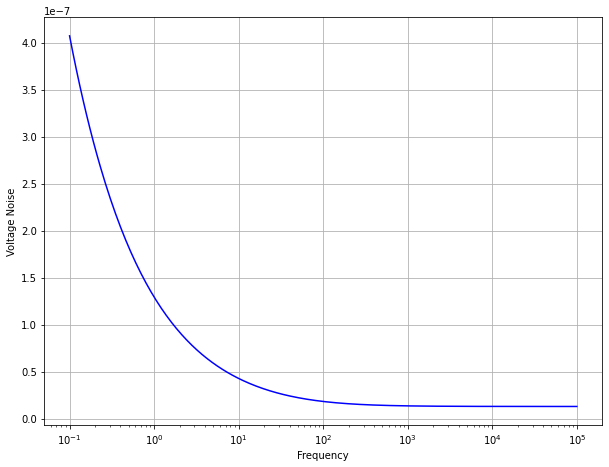

In [5]:
f = np.logspace(-1,5,num=300)
R = 10e3

#flicker noise corner
f_c = 100
e_n_w = np.sqrt(4*k*T*R)
e_n_tot = e_n_w*np.sqrt(1+f_c/f)

# Plot noise voltage spectrum
plot_logxy(f, e_n_tot, 'Frequency', 'Voltage Noise')

## RMS noise versus bandwidth

 - For narrow measurement bandwidths beginning at low frequencies, flicker noise dominates the RMS noise
 - As bandwidth increases, wideband thermal/shot noise density is much higher than that of 1/f noise, so the total noise can be approximated by white noise alone
 - For applications requiring high precision at very low frequencies, 1/f noise can have a substantial impact

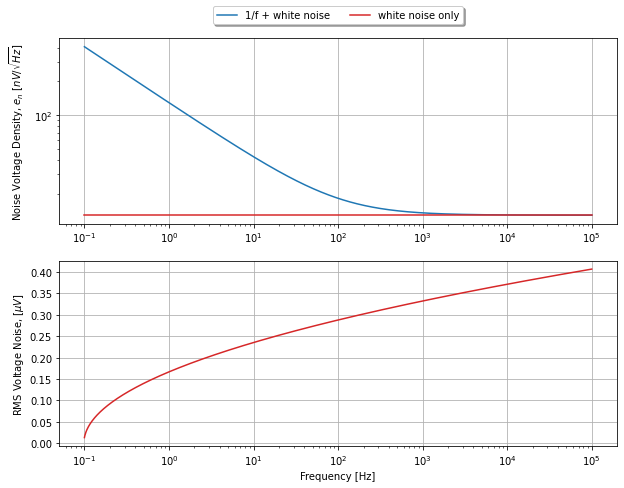

In [14]:
""" RMS Noise vs Bandwidth """
k = 1.38e-23
f = np.logspace(-1,5,num=1000)
T = 300
R = 10e3

#flicker noise corner
f_c = 100

e_n_w_2 = 4*k*T*R
e_n_w = np.sqrt(e_n_w_2)
e_n_tot = e_n_w*np.sqrt(1+f_c/f)
e_n_tot_2 = e_n_tot**2

vn2 = np.cumsum(e_n_tot_2)
vn_rms = np.sqrt(vn2)
vn_w_2 = np.cumsum(e_n_w_2*np.ones(np.shape(f)))
vn_w_rms = np.sqrt(vn_w_2)

 # Plot noise voltage spectrum
fig, ax = plt.subplots(2, figsize=(10.0,7.5))
ax[0].loglog(f, 1e9*(e_n_tot), label=r'1/f + white noise')
ax[0].loglog(f, 1e9*(e_n_w*np.ones(np.shape(f))), color='tab:red', label = 'white noise only')
ax[0].set_ylabel(r'Noise Voltage Density, $e_n$ $[nV/\sqrt{Hz}]$')
ax[0].grid()

# Plot the RMS noise as a function of bandwidth
#ax[1].semilogx(f, 1e6*vn_rms)
ax[1].semilogx(f, 1e6*vn_w_rms, color='tab:red')
ax[1].set_ylabel(r'RMS Voltage Noise, $[\mu V]$')
ax[1].set_xlabel(r'Frequency [Hz]')
ax[1].grid()
fig.align_ylabels(ax[:])

ax[0].legend()
ax[0].legend(loc='upper center', ncol=2, fancybox=True, 
           shadow=True, bbox_to_anchor=(0.5,1.2) )
       